In [2]:
import pandas as pd
df = pd.read_csv("cleaned_dataset.csv")
# Load the dataset
# Extract the country name and year by splitting the 'Country_Name' column
df[['Country', 'Year']] = df['Country Name'].str.split('_', expand=True)

# Convert the 'Year' column to integer
df['Year'] = df['Year'].astype(int)

# Filter the data for the years 2018-2023
df_recent = df[df['Year'].between(2018, 2023)]

# Filter rows where MPI > 0.15
df_recent_affected = df_recent[df_recent['Multidimensional poverty headcount ratio (UNDP) (% of population)'] > 15]

# Count how many years MPI > 0.15 for each country
affected_counts = df_recent_affected.groupby('Country').size()

# Filter countries that have MPI > 0.15 in at least 4 out of the last 5 years
countries_with_4_years = affected_counts[affected_counts >= 4].index

# Display the unique country names
print(countries_with_4_years)

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_dataset.csv'

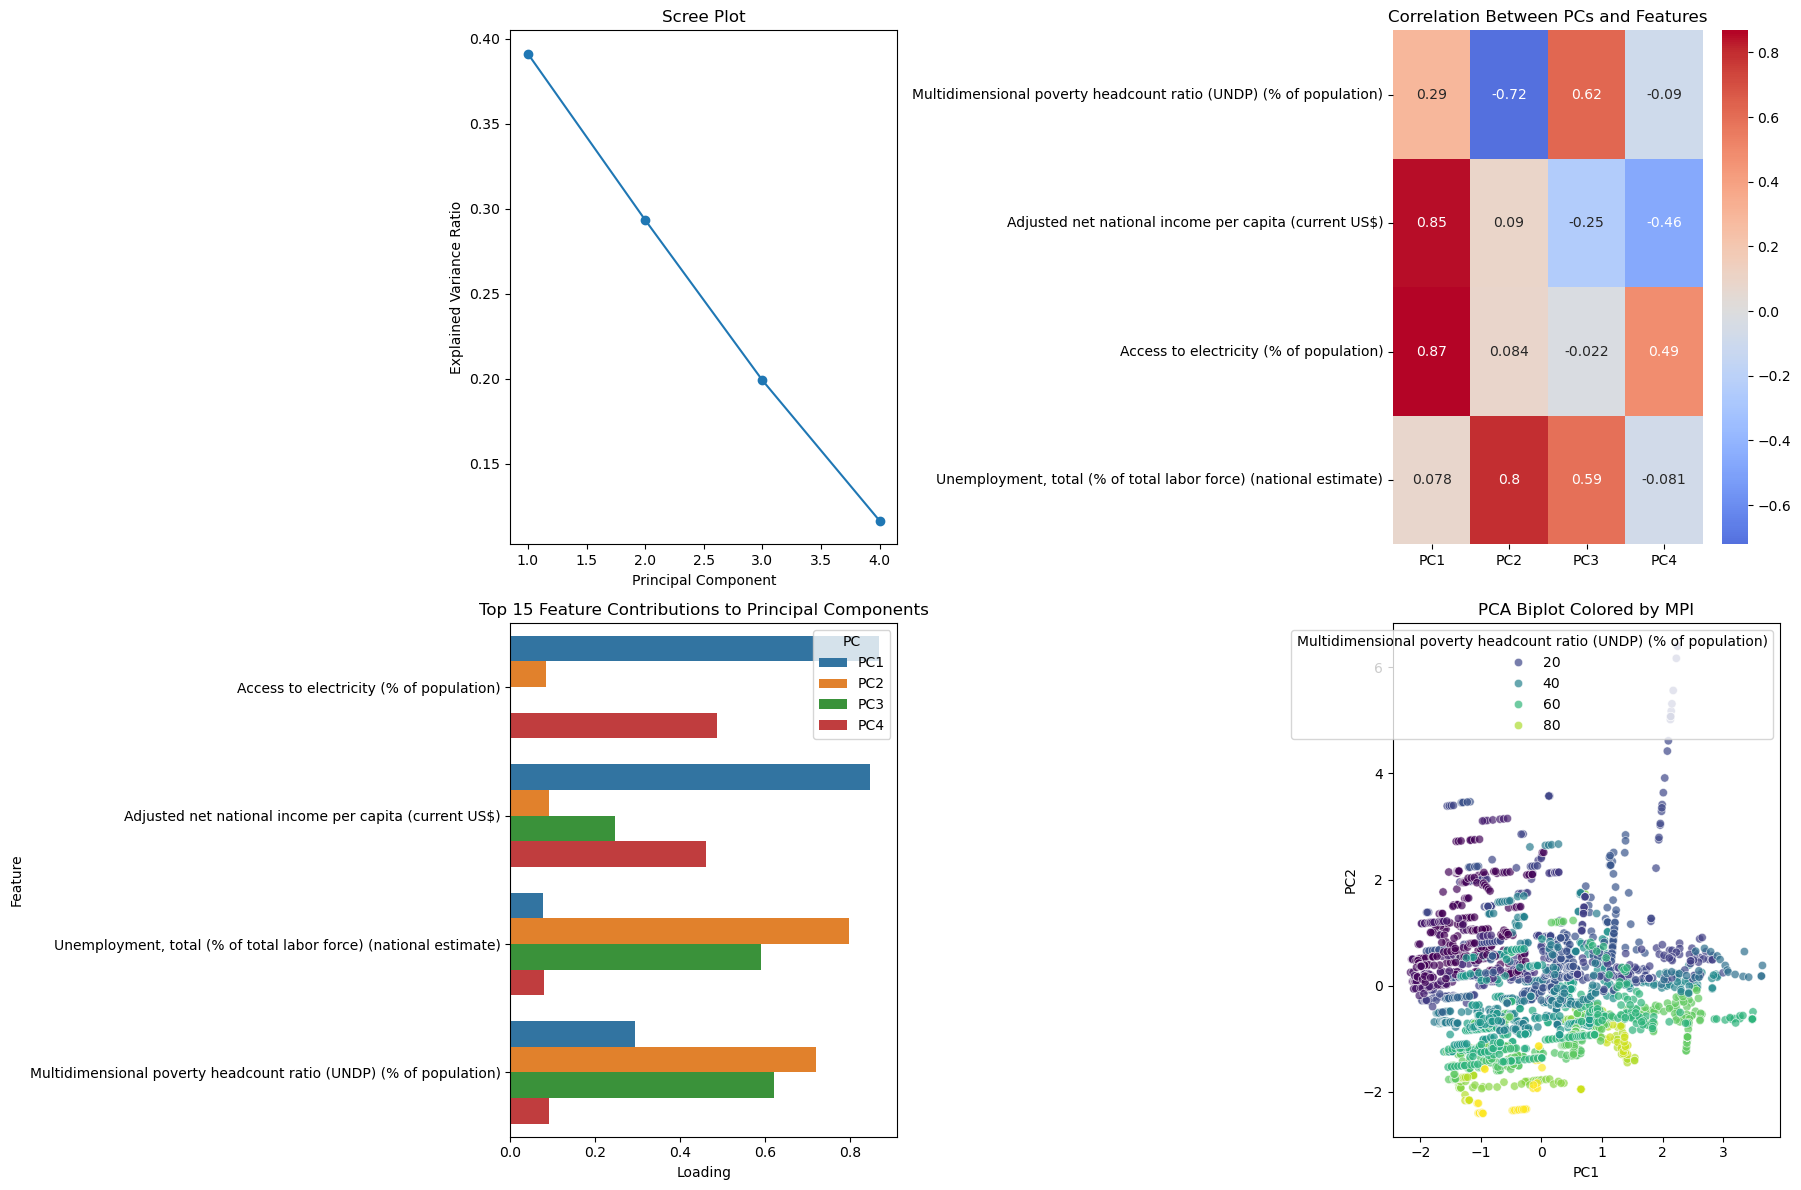

Explained Variance Ratios: [0.39109863 0.29336749 0.19909298 0.1164409 ]
Cumulative Variance: [0.39109863 0.68446612 0.8835591  1.        ]


In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("cleaned_with_hdi.csv")

# Extract the country name and year from the 'Country_Year' column
df[['Country', 'Year']] = df['Country_Year'].str.split('_', expand=True)

# Convert the 'Year' column to integer
df['Year'] = df['Year'].astype(int)

# Filter the data for the years 2018-2023
df_recent = df[df['Year'].between(2018, 2023)]

# Filter rows where MPI > 0.15 (Multidimensional poverty headcount ratio)
df_recent_affected = df_recent[df_recent['Multidimensional poverty headcount ratio (UNDP) (% of population)'] > 15]

# Count how many years MPI > 0.15 for each country
affected_counts = df_recent_affected.groupby('Country').size()

# Filter countries that have MPI > 0.15 in at least 4 out of the last 5 years
countries_with_4_years = affected_counts[affected_counts >= 4].index

# Filter the cleaned dataset for the most affected countries
df_cleaned = df[df['Country'].isin(countries_with_4_years)]

# Now applying PCA

# Define the features for PCA
features = ['Multidimensional poverty headcount ratio (UNDP) (% of population)', 
            'Adjusted net national income per capita (current US$)', 
            'Access to electricity (% of population)', 
            'Unemployment, total (% of total labor force) (national estimate)']

# Select the relevant columns and drop rows with missing values
df_pca = df_cleaned[features].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Apply PCA
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(principal_components, 
                      columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Concatenate the PCA results with the original data
full_df = pd.concat([df_cleaned.reset_index(drop=True), pca_df], axis=1)

# Plot the results
plt.figure(figsize=(18, 12))

# Scree plot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

# Heatmap of correlations between PCA components and selected features
corr_matrix = full_df[features + list(pca_df.columns)].corr()
plt.subplot(2, 2, 2)
sns.heatmap(corr_matrix.loc[features, pca_df.columns], 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between PCs and Features')

# Top loadings
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=features)

plt.subplot(2, 2, 3)
top_loadings = loadings.abs().stack().nlargest(15).reset_index()
top_loadings.columns = ['Feature', 'PC', 'Loading']
sns.barplot(x='Loading', y='Feature', hue='PC', data=top_loadings)
plt.title('Top 15 Feature Contributions to Principal Components')

# PCA Biplot
plt.subplot(2, 2, 4)
sns.scatterplot(x='PC1', y='PC2', data=full_df, 
                hue='Multidimensional poverty headcount ratio (UNDP) (% of population)', 
                palette='viridis', alpha=0.7)
plt.title('PCA Biplot Colored by MPI')

plt.tight_layout()
plt.show()

# Print explained variance ratios
print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))
